In [1]:
cd ..

/work


In [2]:
%load_ext autoreload
%autoreload 2

import time 
from src.dbscan import *
from src.utils import *
from src.metrics import *
from src.clusterization_performance import *
from src.datasets import Dataset
from src.dbscanrn_optimized import *
from src.dbscanrn import *
from src.normalization import *

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(0)
# plt.style.use('dark_background')

lecture_dataset
2
12
14.886856079101562
dbscan_lecture_dataset_D2_R12_m4_e2_euclidean_distance


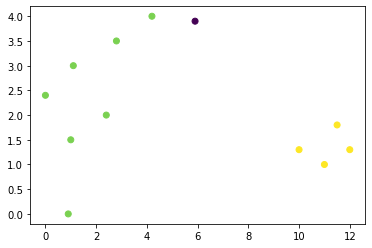

0.016847610473632812
cluto-t7-10k
2
10000
25.554656982421875
dbscan_cluto-t7-10k_D2_R10000_m4_e2_euclidean_distance


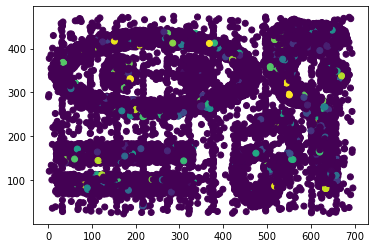

0.020874977111816406
complex9
2
3031
19.73414421081543
dbscan_complex9_D2_R3031_m4_e2_euclidean_distance


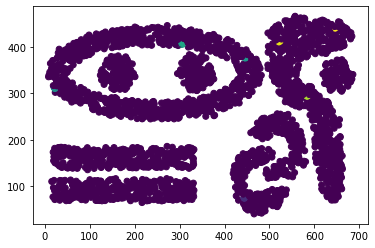

0.015461206436157227


In [21]:
import json
 
f = open('./configs/dbscan.json')
 
config = json.load(f)

for dataset in config.keys():
    conf = config[dataset]
    if not conf['disable']:
        dataset = Dataset(conf['path'])
        X, y = dataset.X, dataset.y

        #################### Clusterization ###########################
        timer_start = time.time()
        params = {
            'epsilon': 2,
            'minPts': 4,
            'similarity': euclidean_distance
        }
        params.update(conf['params'])

        algorithm = DBSCAN(**params)

        name = get_name(
            algorithm_name=algorithm.name, 
            dataset_name=conf['name'], 
            n_dimentions=dataset.n_dimentions, 
            n_rows=dataset.n_rows,
            **params
        )
        print(name)
        algorithm.log_output = f'./out/LOG_{name}.log'
        algorithm.fit_transform(X)
        total_runtime = (time.time() - timer_start) * 1000

        display_points(algorithm.X, algorithm.y_pred, numerate=False)
        score = evaluate(algorithm.y_pred, y, algorithm.X)

        ######################### OUT ##################################
        timer_start = time.time()
        logs = algorithm.get_logs()
        mask = logs['operation'] == 'similarity_calculation'        

        # similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
        similarity_calculation = logs[mask].groupby('point_id').sum().reset_index()
        similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

        out = pd.DataFrame({
            'point_id': np.arange(dataset.n_rows),
            'x': algorithm.X[:, 0],
            'y': algorithm.X[:, 1],
            'point_type': algorithm.state, # 1 - core, 0 - border, -1 - noise
            'CId': algorithm.y_pred # clusters: cluster identifier or -1 in the case of noise points
        })

        out = out.merge(similarity_calculation, on='point_id')
        out.to_csv(f'./out/OUT_{name}.csv', index=False)
        saving_OUT_time = (time.time() - timer_start) * 1000

        ######################### STAT #########################
        timer_stat = time.time()
        stat = pd.DataFrame({
            'name of the input fil': dataset.name,
            '# of dimensions of a point': dataset.n_dimentions,
            '# of points in the input file': dataset.n_rows,
            'epsilon': params['epsilon'] if 'epsilon' in params else '',
            'minPts': params['minPts'] if 'minPts' in params else '',
            'k':  params['k'] if 'k' in params else '',
            'similarity': params['similarity'].__name__,
            'values of dimensions of a reference point': '',
            'reading the input file': dataset.runtime,
            'normalization of vectors': '',
            "Eps-neighborhood timer": logs['time [ms]'][logs['operation'] == 'Eps_time'].sum(),
            'Clustering timer': logs['time [ms]'].max(),
            'saving results to OUT': saving_OUT_time,
            'total runtime': total_runtime,
            '# of discovered clusters': sum(out['CId'] > -1),
            '# of discovered noise points': sum(out['point_type'] == -1),
            '# of discovered core points': sum(out['point_type'] == 1),
            '# of discovered border points': sum(out['point_type'] == 0),
            'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
            '|TP|': score['TP'],
            '|TN|': score['TN'],
            '# of pairs of points': len(algorithm.y_pred),
            'RAND': score['rand_score'],
            'Purity': score['purity'],
            'Silhouette coefficient': score['silhouette_score_euclidean'],
            'Davies Bouldin': score['davies_bouldin_score']
        }, index=['values']).T
        stat_time = time.time() - timer_stat
        print(stat_time)
        stat.to_csv(f'./out/STAT_{name}.csv', index=False)

        ######################### DEBUG #########################
        mask1 = logs['operation'] == '|Eps_neighbors|'
        mask2 = logs['operation'] == 'Eps_neighbor_id'

        debug1 = (
            logs[mask1]
            .pivot_table(
                index=['point_id'], 
                columns=['operation'], 
                values= 'value', 
            )
        )
        debug1.reset_index(col_level=1, inplace=True)
        debug1.columns.name = None

        debug2 = (
            logs[mask2]
            .pivot_table(
                index=['point_id'], 
                columns=['operation'], 
                values= 'string', 
                aggfunc=lambda x: ' '.join(x)
        ))   
        debug2.reset_index(col_level=1, inplace=True)
        debug2.columns.name = None

        debug = debug1.merge(debug2, on='point_id')
        debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)